In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

#### Load data
First, I am going to analyze the data of the US videos

In [4]:
df = pd.read_csv("./data/USvideos.csv")
print('Number of youtube videos in dataframe: ', len(df.index))
df.head()

Number of youtube videos in dataframe:  40949


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


## Interesting Things to explore
- Most Popular/Non-Popular tags. (most liked,most disliked)
- Number of tags comparative to popularity
- Is disabling comments affects the popularity of the video
- Views per like, views per dislike
- More popular means more likeable?
- Chronological analysis of viewings + ratings + comments (maybe get some events involved - Christmas, Summer, New Years day etc.)
- NLP on Title + Description to Tags, in order to build a tag recommendation algorithm
- NLP on Tags + Description + Category to Title, in order to provide title recommendation algorithm. These videos are popular videos, meaning they have appealing titles. Let's build a system, that judging by content, can provide the most appropriate title.

### Categories and Popularity

In [35]:
# count category occurences
occurences = df['category_id'].value_counts()
# category names
map_categories = {}
with open('data/US_category_id.json') as json_file:
    data_category = json.load(json_file)
    for category in data_category['items']:
        int_id = int(category['id'])
        occ = 0
        if int_id in occurences:
            occ = occurences[int_id]
        map_categories[int_id] = [category['snippet']['title'],occ]
# create new dataframe with categories and appearances
df_categories = pd.DataFrame.from_dict(map_categories, orient='index', columns=['category_name', 'count'])
# add category name on the main dataframe
for i in map_categories.keys():
    df.loc[df['category_id'] == i,'category_name'] = map_categories[i][0]

#### Plot Category Occurences in dataset

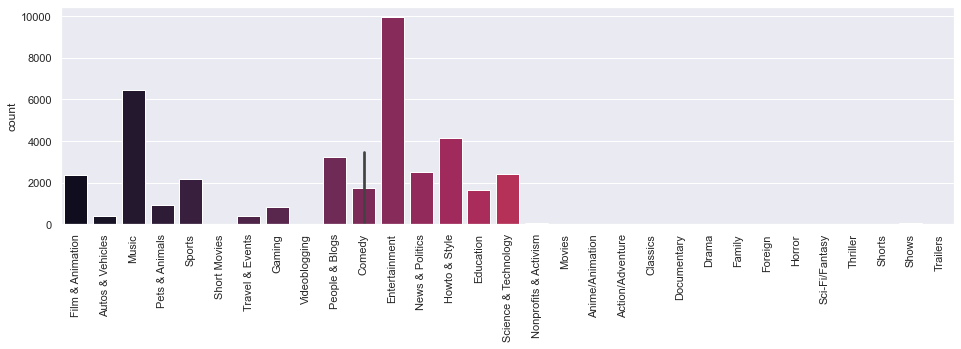

In [79]:
sns.set(style="darkgrid")
f, ax1 = plt.subplots(1, 1, figsize=(16, 4), sharex=True)
categ_plot = sns.barplot(x='category_name', y='count', data=df_categories, palette="rocket", ax=ax1)
categ_plot.set_xticklabels(categ_plot.get_xticklabels(), rotation='vertical')
categ_plot.set_xlabel("", fontsize=12)
plt.show()

### Tags and Popularity

In [17]:
def discretize(tags):
    tags = tags.replace('"','')
    discrete_tags = tags.split('|')
    return discrete_tags

In [19]:
discrete_tags = {}
for index, row in df.iterrows():
    discrete_tags[row['video_id']] = discretize(row['tags'])

Insert new field for tag number in the dataframe

In [22]:
for i in discrete_tags.keys():
    df.loc[df['video_id'] == i,'number_of_tags'] = len(discrete_tags[i])

Create two very useful dataframes, containing aggregating values
- sum
- mean

In [58]:
df_sums = df.groupby('category_id').sum()
df_means = df.groupby('category_id').mean()

Prepare the data for the plots

In [85]:
mean_tags_per_category = df_means['number_of_tags'].tolist()
categories = df['category_name'].unique().tolist()
mean_views_per_category = df_means['views'].tolist()
viewspertag = [i / j for i, j in zip(mean_views_per_category, mean_tags_per_category)]

Correlation between **Tags and Views** with 2 simple charts

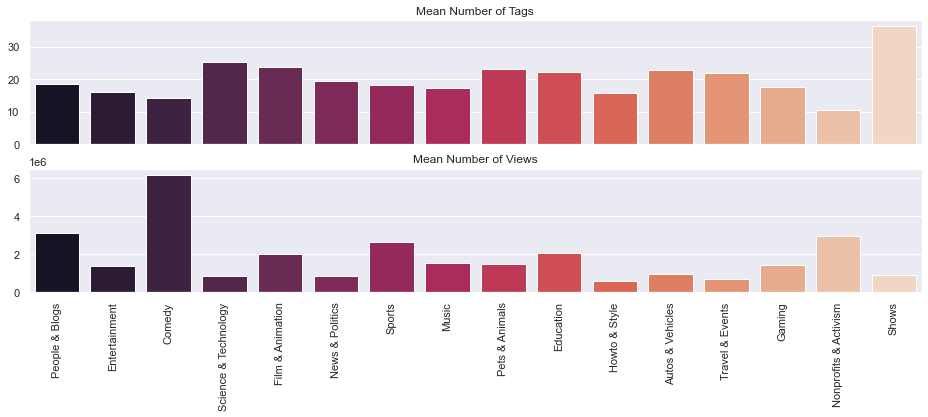

In [82]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 5), sharex=True)
tag_plot = sns.barplot(x=categories, y=mean_tags_per_category, palette="rocket", ax=ax1)
tag_plot.set_xticklabels(tag_plot.get_xticklabels(), rotation='vertical')
tag_plot.set_xlabel("", fontsize=12)
ax1.set_title('Mean Number of Tags')
viewspertag_plot = sns.barplot(x=categories, y=mean_views_per_category, palette="rocket", ax=ax2)
viewspertag_plot.set_xticklabels(viewspertag_plot.get_xticklabels(), rotation='vertical')
viewspertag_plot.set_xlabel("", fontsize=12)
ax2.set_title('Mean Number of Views')
plt.show()

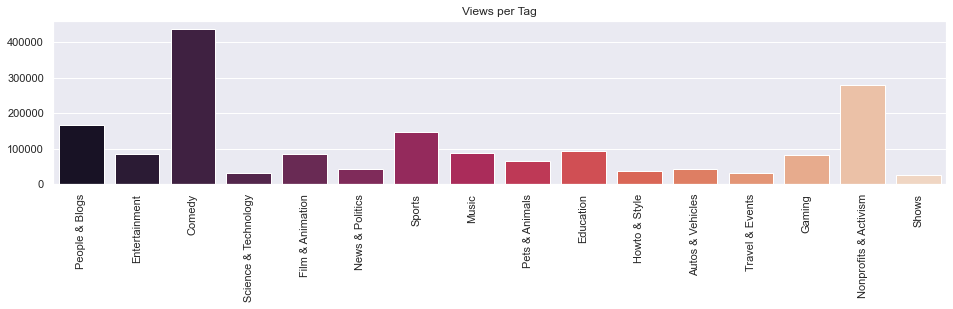

In [89]:
f, ax1 = plt.subplots(1, 1, figsize=(16, 3), sharex=True)
categ_plot = sns.barplot(x=categories, y=viewspertag, palette="rocket", ax=ax1)
categ_plot.set_xticklabels(categ_plot.get_xticklabels(), rotation='vertical')
categ_plot.set_xlabel("", fontsize=12)
ax1.set_title('Views per Tag')
plt.show()

From the above graph, we can understand how many views does each tag generate in average for each category

**Most popular tags**

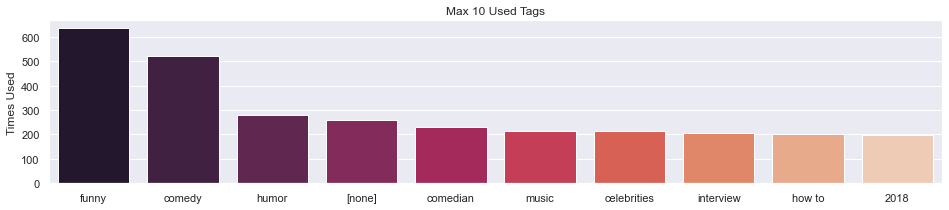

In [115]:
tag_vocab = {}
for taglist in discrete_tags.values():
    for tag in taglist:
        if tag not in tag_vocab.keys():
            tag_vocab[tag] = 1
        else:
            tag_vocab[tag] += 1

tags = []
count = []
for k, c in sorted(tag_vocab.items(), key=lambda item: item[1], reverse=True):            
    tags.append(k)
    count.append(c)
    
f, ax1 = plt.subplots(1, 1, figsize=(16, 3), sharex=True)
categ_plot = sns.barplot(x=tags[0:10], y=count[0:10], palette="rocket", ax=ax1)
categ_plot.set_xticklabels(categ_plot.get_xticklabels())
categ_plot.set_ylabel("Times Used", fontsize=12)
ax1.set_title('Max 10 Used Tags')
plt.show()

### Comments and popularity

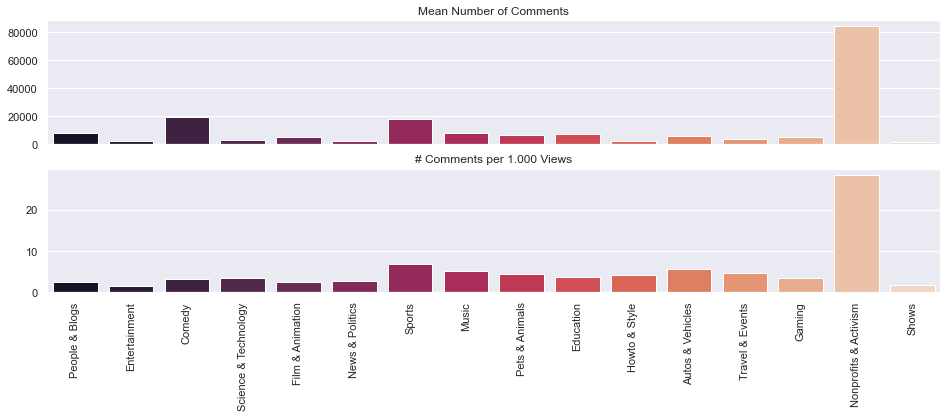

In [97]:
mean_comments_per_category = df_means['comment_count'].tolist()
commentsperview = [i*1000 / j for i, j in zip(mean_comments_per_category, mean_views_per_category)]

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 5), sharex=True)
tag_plot = sns.barplot(x=categories, y=mean_comments_per_category, palette="rocket", ax=ax1)
tag_plot.set_xticklabels(tag_plot.get_xticklabels(), rotation='vertical')
tag_plot.set_xlabel("", fontsize=12)
ax1.set_title('Mean Number of Comments')
viewspertag_plot = sns.barplot(x=categories, y=commentsperview, palette="rocket", ax=ax2)
viewspertag_plot.set_xticklabels(viewspertag_plot.get_xticklabels(), rotation='vertical')
viewspertag_plot.set_xlabel("", fontsize=12)
ax2.set_title('# Comments per 1.000 Views')
plt.show()